# Transmission Matrix

Samples:  5040 630 631
Batch:  158 20 20
Batch shapes: torch.Size([32, 256, 256]), torch.Size([32, 32, 32])


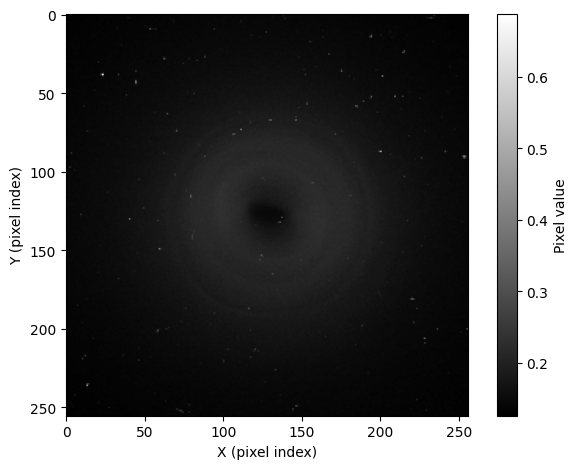

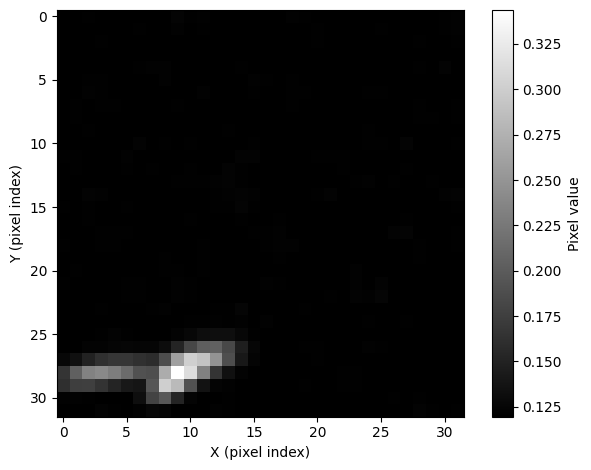

Detected framework: PyTorch
Framework:           PyTorch
Model:               TransmissionMatrix
Device / dtype:      unavailable / N/A
Parameters:          67,108,864 total
                     67,108,864 trainable
                     0 non-trainable
Size:                256.00 MB
Sub-modules:         2


In [1]:
# pip install xflow-py
from xflow import ConfigManager, FileProvider, PyTorchPipeline, show_model_info
from xflow.data import build_transforms_from_config
from xflow.utils import load_validated_config, plot_image

from TM import TransmissionMatrix
from config_utils import load_config

# Configuration
# config_manager = ConfigManager(load_validated_config("TM.yaml"))
config_manager = ConfigManager(load_config("TM.yaml"))
config = config_manager.get()
config_manager.add_files(config["extra_files"])

# Data pipeline
provider = FileProvider(config["paths"]["dataset"]).subsample(fraction=1, seed=config["seed"])
train_provider, temp_provider = provider.split(ratio=config["data"]["train_val_split"], 
                                               seed=config["seed"])
val_provider, test_provider = temp_provider.split(ratio=config["data"]["val_test_split"], 
                                                  seed=config["seed"])
transforms = build_transforms_from_config(config["data"]["transforms"]["torch"])

def make_dataset(provider):
    return PyTorchPipeline(provider, transforms).to_memory_dataset(config["data"]["dataset_ops"])

train_dataset = make_dataset(train_provider)
val_dataset = make_dataset(val_provider)
test_dataset = make_dataset(test_provider)

print("Samples: ",len(train_provider),len(val_provider),len(test_provider))
print("Batch: ",len(train_dataset),len(val_dataset),len(test_dataset))

for left_parts, right_parts in test_dataset:
    # batch will be a tuple: (right_halves, left_halves) due to split_width
    print(f"Batch shapes: {left_parts.shape}, {right_parts.shape}")
    plot_image(left_parts[0])
    plot_image(right_parts[0])
    break

# Model
model = TransmissionMatrix(
    input_height = config["data"]["input_image_size"][0],
    input_width = config["data"]["input_image_size"][1],
    output_height = config["data"]["output_size"][0],
    output_width = config["data"]["output_size"][1],
    initialization = "xavier"
)

show_model_info(model)

In [ ]:
import torch
from utils import make_beam_param_metric
from functools import partial

import xflow.extensions.physics
from xflow.trainers import TorchTrainer, build_callbacks_from_config
from xflow.extensions.physics.beam import extract_beam_parameters

# 1) device/model/optim/loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config['training']['learning_rate'])

# 2) callbacks (unchanged) + any custom wiring
callbacks = build_callbacks_from_config(
    config=config["callbacks"],
    framework=config["framework"],   # e.g. "torch"
)
callbacks[-1].set_dataset(test_dataset)  # keep dataset closure

# Extract beam parameters
extract_beam_parameters_dict = partial(extract_beam_parameters, as_array=False)
beam_param_metric = make_beam_param_metric(extract_beam_parameters_dict)

# 3) run training
trainer = TorchTrainer(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    callbacks=callbacks,
    output_dir=config["paths"]["output"],
    data_pipeline=train_dataset,
    val_metrics=[beam_param_metric]
)

history = trainer.fit(
    train_loader=train_dataset, 
    val_loader=val_dataset,
    epochs=config['training']['epochs'],
)

# 4) persist
trainer.save_history(f"{config['paths']['output']}/history.json")
trainer.save_model(config["paths"]["output"])  # uses model.save_model(...) if available
config_manager.save(output_dir=config["paths"]["output"], config_filename=config["name"])

Starting Training
Total epochs: 100

Epoch 1/100 - 158 batches
input image max pixel: 0.4745, ground truth image max pixel: 0.1899, reconstructed image max pixel: 0.4998
[==============================] 158/158 (100.0%) - ETA: 0s - train_loss: 0.0031 - val_loss: 0.0011                    
Epoch 1 completed in 134.71s - train_loss: 0.0031 - val_loss: 0.0011

Epoch 2/100 - 158 batches
input image max pixel: 0.8444, ground truth image max pixel: 0.4216, reconstructed image max pixel: 0.2465
[==============================] 158/158 (100.0%) - ETA: 0s - train_loss: 0.0010 - val_loss: 0.0009                    
Epoch 2 completed in 130.85s - train_loss: 0.0010 - val_loss: 0.0009

Epoch 3/100 - 158 batches
input image max pixel: 0.5137, ground truth image max pixel: 0.6702, reconstructed image max pixel: 0.2278
[==============================] 158/158 (100.0%) - ETA: 0s - train_loss: 0.0009 - val_loss: 0.0009                    
Epoch 3 completed in 128.97s - train_loss: 0.0009 - val_loss: 0.

# Inference

In [ ]:
import torch
from xflow.extensions.physics.beam import extract_beam_parameters

# Load the trained model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = TransmissionMatrix.load_model('../TM_03/model.pth', device=device)
model.eval()  # Set to evaluation mode

# Clean PyTorch inference - just use forward pass
print("Testing inference...")
with torch.no_grad():
    for batch in test_dataset:
        inputs, targets = batch
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        print(f"Input shape: {inputs.shape}")
        print(f"Target shape: {targets.shape}")
        
        # Pure PyTorch way - same as training!
        reconstructed_images = model(inputs)
        print(f"Reconstructed shape: {reconstructed_images.shape}")
        
        # Plot first sample
        plot_image(inputs[0], title="Input")
        plot_image(reconstructed_images[0], title="Reconstructed") 
        plot_image(targets[0], title="Ground Truth")
        
        # Only process first batch for testing
        break